[![Open in Colab]("https://colab.research.google.com/assets/colab-badge.svg")](https://colab.research.google.com/github/MusicalInformatics/miws23/blob/main/generation_EA/evolutionary_four_part_writing.ipynb)

# Generating Sound & Music with Evolutionary Algorithms

Evolutionary Algorithms are a subset of evolutionary computing; biologically inspired optimization with population-based trial and error search. Loosely speaking, an evolutionary algortihm creates a popultation of entities that can be modified, combined, and evaluated for fitness with respect to an optimization goal. The simplest optimization step works as follows; create a population, check which elements are most fit (best suited to the optimization problem), keep only the most fit, modify and recombine elements to create new element for the next generation, repeat.

### The components:
- genetic representation
- population
- genetic operations: mutation and recombination
- fitness
- selection
- sources of randomness


### Introduction Example:

Evolutionary algorithms are inspired by natural selection. Here is a simple simulation of natural selection (choose the lab): https://phet.colorado.edu/sims/html/natural-selection/latest/natural-selection_en.html

- note all the ways you can change the genetic operations
- note all the ways you can change the fitness function

## The evolutionary algorithm in this notebook

### The components in the code:
- genetic representation: ...
- population: ...
- genetic operations: 
1) point mutation of progression; ...
2) recombination of progression; ...
- fitness: 
1) penalize and encourage several pitch relationships between adjacent chords ...
2) penalize and encourage several pitch relationships between adjacent voices ...
- selection: ...
- sources of randomness: ...

### Getting to know the code:

1. understand the code below and get an overall idea of what the algorithm looks like, maybe draw a flow chart or take some notes. Replace the "..." with examples in the description of the components above. 
2. play around with the optimization loop while changing the modify function: do you see things that could be changed in the genetic representation? what are they and can you change them?
3. write a two step selection; first mutate/modify elements and select the fittest (with some randomness), then recombine them and select the fittest from offspring and parent elements (with some randomness)
4. change the modify function, such that some parts of the genetic representation (the chord sequence) can be fixed (made immutable). This is the most complex task and probably requires some thinking, creativity, and experimentation. Take your time!

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !pip install partitura
    !git clone https://github.com/MusicalInformatics/miws23
    import sys
    sys.path.insert(0, "./miws23/generation_EA")

In [2]:
import partitura as pt
import numpy as np
from scipy.spatial.distance import pdist
from itertools import product
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from partitura.utils.synth import synthesize
import IPython.display as ipd
from helpers_EA import (partFromFourPartProgression, randomword)

In [3]:
chord_types = {
    # position 1: soprano in C
    "a":(10,3,4),
    "b":(3,3,4),
    "c":(12,6,6),
    "d":(5,6,6),
    # "e":(6,5,4), # 6
    # "f":(14,5,4), # 6
    # "g":(3,4,8), # 6
    # "h":(10,4,8), # 6
    # "i":(3,8,4), # 6 (5 doubled)
    # "j":(10,8,4), # 6 (5 doubled)
    # position 2: soprano in G
    "k":(8,3,3),
    "l":(1,3,3),
    "m":(5,6,3), #(5 doubled)
    "n":(12,6,3), #(5 doubled)
    "o":(3,6,5),
    "p":(10,6,5),
    "q":(3,3,8), # (5 doubled)
    "r":(10,3,8), # (5 doubled)
    # "s":(6,8,5), # 6
    # "t":(14,8,5), # 6 
    # "u":(3,4,5), # 6 (5 doubled)
    # "v":(10,4,5), # 6 (5 doubled)
    # "w":(6,5,8), # 6 (5 doubled)
    # "x":(14,5,8), # 6 (5 doubled)
    # position 3: soprano in E
    "y":(1,5,6), 
    "z":(8,5,6),
    "ö":(5,4,3),
    "ü":(12,4,3),
    "ä":(5,8,6), # (5 doubled)
    ".":(12,8,6), # (5 doubled) 
}

In [4]:
class FourPartChord:
    """
    the Chord class representing a chord made of 4 notes of a scale.
    For diatonic scales the intervals between notes are thirds.

    Parameters
    ----------
    chord_type: str
        the type of the chord
    offset : int
        the MIDI pitch of scale degree 0
    scale : np.array
        the scale from which the chord is built

    """
    def __init__(self, 
                 chord_type = "a",
                 offset = 48,
                 scale = np.array([0,2,4,5,7,9,11]),
                ):
        self.chord_type = chord_type
        self.offset = offset
        self.scale = scale
        lowest_offset = offset % 12
        self.whole_scale = np.concatenate([self.scale + lowest_offset + 12 * octave  
                                           for octave in np.arange(10)])
        self.intervals = chord_types[self.chord_type]
        self.soprano = None
        self.alto = None
        self.tenor = None
        self.bass = None
        self.pitch_computed = False
        self.id = randomword(4)
        
    def compute_pitch(self,
                      given_pitch, # midi pitch of given melody
                      given_voice): # voice (0-3) of given melody
        if not self.pitch_computed:
            given_note_idx = np.where(self.whole_scale==given_pitch)[0]
            if len(self.whole_scale) == 0:
                raise ValueError("given note needs to be in the scale")
            
            if given_voice == 0: 
                self.soprano = self.whole_scale[given_note_idx]
                self.alto = self.whole_scale[given_note_idx - (self.intervals[2] - 1) ]
                self.tenor = self.whole_scale[given_note_idx - (self.intervals[2] - 1) - (self.intervals[1] - 1) ]
                self.bass = self.whole_scale[given_note_idx - (self.intervals[2] - 1) - (self.intervals[1] - 1) - (self.intervals[0] - 1) ]
            elif given_voice == 1: 
                self.soprano = self.whole_scale[given_note_idx + (self.intervals[2] - 1) ]
                self.alto = self.whole_scale[given_note_idx ]
                self.tenor = self.whole_scale[given_note_idx - (self.intervals[1] - 1) ]
                self.bass = self.whole_scale[given_note_idx - (self.intervals[1] - 1) - (self.intervals[0] - 1)  ]
            elif given_voice == 2: 
                self.soprano = self.whole_scale[given_note_idx + (self.intervals[2] - 1) + (self.intervals[1] - 1)]
                self.alto = self.whole_scale[given_note_idx + (self.intervals[1] - 1) ]
                self.tenor = self.whole_scale[given_note_idx]
                self.bass = self.whole_scale[given_note_idx - (self.intervals[0] - 1) ] 
            elif given_voice == 3: 
                self.soprano = self.whole_scale[given_note_idx + (self.intervals[2] - 1) + (self.intervals[1] - 1) + (self.intervals[0] - 1)]
                self.alto = self.whole_scale[given_note_idx + (self.intervals[1] - 1) + (self.intervals[0] - 1) ]
                self.tenor = self.whole_scale[given_note_idx + (self.intervals[0] - 1)]
                self.bass = self.whole_scale[given_note_idx]  

            self.pitch_computed = True

In [5]:
class FourPartProgression:
    """
    the Progression class representing a sequence of chords
    """
    def __init__(self,
                 c_type_sample = None,
                 number_of_chords = 8, 
                 offset = 48,
                 scale = np.array([0,2,4,5,7,9,11])):
        
        self.c_types = list(chord_types.keys())
        if c_type_sample is not None:
            self.c_type_sample = np.random.choice(self.c_types, number_of_chords)
        else:
            self.c_type_sample = np.random.choice(self.c_types, number_of_chords)
        self.chords = [FourPartChord(self.c_type_sample[c], offset = offset, scale = scale) for c in range(number_of_chords)]
        self.number_of_chords = number_of_chords
        self.id = randomword(10)
    
    def copy(self):
        return FourPartProgression(number_of_chords = self.number_of_chords,
                                   c_type_sample = self.c_type_sample)
    
    def set_voice(self, melody, voice):
        for cidx, melody_pitch in enumerate(melody):
            self.chords[cidx].compute_pitch(melody_pitch, voice)

    def point_mutate(self, idx = None, c_type_sample = None):   
        if idx is None:
            idx = np.random.randint(0,self.number_of_chords)
        if c_type_sample is None:
            c_type_sample = np.random.choice(self.c_types, 1)
        self.c_type_sample[idx] = c_type_sample[0]
        self.chords[idx] = FourPartChord(c_type_sample[0])
        
    def join(self, 
             another,
             idx = None):
        """
        create two new progressions by joining two existing ones
        where the split of chords is defined by an index array
        """
        if another.number_of_chords != self.number_of_chords:
            raise ValueError("progressions must have the same number of chords")

        if idx is None:
            idx = np.unique(np.random.randint(0,self.number_of_chords,self.number_of_chords//2))

        new_progression = FourPartProgression(number_of_chords = self.number_of_chords)
        new_another_progression = FourPartProgression(number_of_chords = self.number_of_chords)
        for k in range(self.number_of_chords):
            if k in idx:
                new_progression.chords[k] = self.chords[k]
                new_another_progression.chords[k] = another.chords[k]
            else:
                new_progression.chords[k] = another.chords[k]
                new_another_progression.chords[k] = self.chords[k]
        return new_progression, new_another_progression

## Optimization loop

In [6]:
class FourPartOptimizer:
    def __init__(self):
        self.population = None   

    def modify(self, population, number_to_mutate, number_to_recombine):
        # point mutation of chord
        subpop4 = np.random.choice(population, number_to_mutate)
        for element in subpop4:
            cidx = np.random.randint(len(element.chords))
            new_element = element.copy()
            new_element.point_mutate(cidx)
            population.append(new_element)
            
        # recombination of sequence
        subpop1 = np.random.choice(population, number_to_recombine)
        subpop2 = np.random.choice(population, number_to_recombine)
        for element0, element1 in zip(subpop1, subpop2):
            elnew1, elnew2 = element0.join(element1)
            population.append(elnew1)
            population.append(elnew2)
        
        return population
    
    def fitness(self, progression, melody, voice):
        progression.set_voice(melody, voice)
        index_range = (0, progression.number_of_chords)
        fit = 0.0
        for c0, c1 in zip(progression.chords[index_range[0]:index_range[1]], 
                          progression.chords[index_range[0]+1:index_range[1]+1]):
            melodic_lines = np.array([c1.soprano - c0.soprano, c1.alto - c0.alto, c1.tenor - c0.tenor])
            melodic_lines_bass = np.array([c1.soprano - c0.soprano, c1.alto - c0.alto, c1.tenor - c0.tenor, c1.bass - c0.bass])
            fit += np.sum(np.abs(melodic_lines)) # penalize large leaps
            if (melodic_lines_bass > 0).sum() >= 3:
                fit += 5 # similar motion
            elif (melodic_lines_bass < 0).sum() >= 3:
                fit += 5 # similar motion

            intervals0 = np.array([c0.soprano - c0.alto, c0.alto - c0.tenor, c0.soprano - c0.tenor])
            intervals1 = np.array([c1.soprano - c1.alto, c1.alto - c1.tenor, c1.soprano - c1.tenor])
            for i0, i1 in zip(intervals0, intervals1):
                if i0 == i1: 
                    if np.abs(i0) == 7:
                        fit += 10 # parallel fifths
                    elif np.abs(i0) == 12:
                        fit += 10 # parallel octave
            
        # add a small random number for hashing
        fit += np.random.rand(1)[0]
        return float(fit) 
    
    def select(self, population, melody, voice, number_to_keep):
        pop = {ele.id:ele for ele in population}
        fitness_dict = {self.fitness(ele, melody, voice):ele.id for ele in population}
        sorted_fitness = list(fitness_dict.keys())
        sorted_fitness.sort()
        new_pop = [pop[fitness_dict[k]] for k in sorted_fitness[:number_to_keep]]
        best_prog = pop[fitness_dict[sorted_fitness[0]]]
        return new_pop, sorted_fitness, best_prog

    def run(self,
            epochs = 200,
            population_size = 100,
            replacement_ratio = 0.2,
            mutation_ratio = 0.2,
            combination_ratio = 0.2,
            new_population = True,
            melody = np.array([48,50,53,48,50,47,43,48]),
            voice = 3,
            number_of_chords = 8,
            save_part = 40):
        

        part = None
        number_to_keep = int((1 - replacement_ratio) * population_size)
        number_to_sample = int((replacement_ratio) * population_size)
        number_to_mutate = int(mutation_ratio  * population_size)
        number_to_recombine = int(combination_ratio  * population_size)

        if new_population:
            population = [FourPartProgression(number_of_chords = number_of_chords) for po in range(population_size)]    
        else:
            population = self.population
        
        for epoch in range(epochs): 
            population = self.modify(population, number_to_mutate, number_to_recombine) 
            population, sorted_fitness, best_prog = self.select(population, melody, voice, number_to_keep) 
            print(f"Epoch {epoch} best fitness: {sorted_fitness[0]:.4f}")
            if epoch % save_part == 0:
                part = partFromFourPartProgression(best_prog, 
                                part = part,
                                quarter_duration = 1,
                                time_offset = (epoch // save_part) *8)
            
            population += [FourPartProgression(number_of_chords = number_of_chords) for po in range(number_to_sample)]

        self.population = population
        
        pt.score.add_measures(part)
        
        return self.population, part

In [7]:
exp = FourPartOptimizer()
pop, part = exp.run()

Epoch 0 best fitness: 94.1393
Epoch 1 best fitness: 80.8734
Epoch 2 best fitness: 80.9697
Epoch 3 best fitness: 80.3443
Epoch 4 best fitness: 80.1839
Epoch 5 best fitness: 73.6417
Epoch 6 best fitness: 73.8082
Epoch 7 best fitness: 73.1147
Epoch 8 best fitness: 73.9636
Epoch 9 best fitness: 73.7112
Epoch 10 best fitness: 73.0957
Epoch 11 best fitness: 69.3233
Epoch 12 best fitness: 69.6434
Epoch 13 best fitness: 69.1746
Epoch 14 best fitness: 69.3140
Epoch 15 best fitness: 69.0911
Epoch 16 best fitness: 69.0120
Epoch 17 best fitness: 69.1979
Epoch 18 best fitness: 69.0571
Epoch 19 best fitness: 63.4360
Epoch 20 best fitness: 63.7226
Epoch 21 best fitness: 63.3065
Epoch 22 best fitness: 63.3589
Epoch 23 best fitness: 63.5706
Epoch 24 best fitness: 63.6287
Epoch 25 best fitness: 62.1750
Epoch 26 best fitness: 55.5211
Epoch 27 best fitness: 50.6648
Epoch 28 best fitness: 50.3523
Epoch 29 best fitness: 50.0366
Epoch 30 best fitness: 50.9106
Epoch 31 best fitness: 50.0159
Epoch 32 best fitn

In [ ]:
pt.save_musicxml(part, "evolutionary_four_part_writing.musicxml")

## Synthesize

In [8]:
SAMPLE_RATE = 44100

audio = synthesize(part, samplerate=SAMPLE_RATE)
audio /= 4 # a bit quieter
ipd.display(ipd.Audio(data=audio, rate=SAMPLE_RATE, normalize=False))

## Visualize

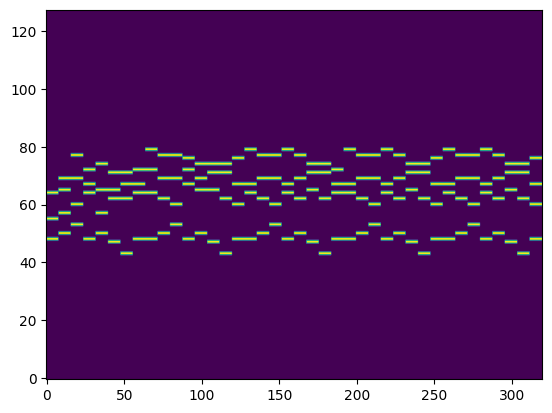

In [9]:
%matplotlib inline
piano_roll = pt.utils.music.compute_pianoroll(part)
plt.imshow(piano_roll.todense(), aspect = "auto", origin="lower")